# 3115 - Lab Programming Machine Learning

## Lab Exercise 11

## Yuvaraj Prem Kumar, 303384

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import operator
import os
%matplotlib inline

plt.style.use('ggplot')

In [2]:
from sklearn.datasets import load_svmlight_file, dump_svmlight_file
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from copy import deepcopy
from random import randint
from scipy import sparse
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings("ignore", message="Changing the sparsity structure")

## Part 1: Implement K-Means Clustering Algorithm

From [3, 4], K-Means is one of the most popular "clustering" algorithms. It is an unsupervised machine learning algorithm, with no pre-determined labels defined. Meaning that we don’t have any target variable as in the case of supervised learning K-means stores *k* centroids that it uses to define clusters. A point is considered to be in a particular cluster if it is closer to that cluster's centroid than any other centroid. K-Means finds the best centroids by alternating between (1) assigning data points to clusters based on the current centroids (2) chosing centroids (points which are the center of a cluster) based on the current assignment of data points to clusters.



The algorithm:
<img src="https://i.imgur.com/ZptQeCD.jpg" width="45%"/>

The objective here is to return *P*, the partition (clustering). We compute a distortion measure $D_P$, whih measures how bad a partition $P\in Part(X)$ for a data set $X \subseteq X$ is.
<img src="https://i.imgur.com/EkRyif3.jpg" width="45%"/>


1. Randomly initialize K centroids. 
2. Assign each datapoint to its nearest centroid (using Euclidean distance)
3. Recomputed centroids by taking mean of all datapoints assigned that that centroid's cluster.
4. Iterate until stopping criteria met (no datapoints change clusters)

**Choosing optimal value of K**

An accurate estimate can be obtained using the Elbow Method plot. We run the algorithm for a range of K (1 to 5) and plot the K values against SSE (Sum of Squared Errors). We select the value of K that causes sudden drop in the sum of squared distances, i.e., the so-called "elbow point" in the plot.

### Iris Dataset exploration

From [1], we have four attributes - sepal length, sepal width, petal length, and petal width - that defines if the flower belongs to one of the three particular classes:
* Iris Setosa
* Iris Versicolour
* Iris Virginica

Based on the dataset description, the following are noted:
1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Missing Attribute Values: None
4. Class Distribution: 33.3% for each of 3 classes

However different from Lab 7, now the dataset source is from [2], which is in the Libsvm format. Each attribute is linearly scale to [-1,1] or [0,1]. Similar to Lab 9, we can use sklearn's *load_svmlight_file* to read the sparse matrix.

In [3]:
iris = load_svmlight_file("iris.scale")
iris

(<150x4 sparse matrix of type '<class 'numpy.float64'>'
 	with 587 stored elements in Compressed Sparse Row format>,
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]))

We have the following helper functions:

**Distance measure**

Similar to Lab 7, for the distance measure we are using the **Euclidean Distance**, which is also the L2 distance:

\begin{equation*}
d(x,x') = \sqrt{{(x_1-x'_2)}^2 +...+ {(x_n-x'_n)}^2}
\end{equation*}

Since the X matrix is a sparse matrix (spicy csr_matrix) we can use built-in "multiply" function as normal numpy functions will not work [8].

**Cluster distance**

This is just the distance of any point from the current cluster assigned

**Get labels**

Returns a label for each piece of data in the dataset. For each element in the dataset, chose the closest centroid. Make that centroid the element's label

**Distortion / Sum of square errors**

As above, minimize total intra-cluster variance, or, the squared error function (distortion).

In addition, the main references are from [3,4,6].

In [4]:
def euclidean_distance(x1, x2):
    eucl_dist = np.sqrt(np.sum((x1-x2).multiply((x1-x2))))
    return eucl_dist


def cluster_distance(X, centroid):
    m = X.shape[0]
    cluster = np.zeros(m)
    for i in range(m):
        cluster[i] = euclidean_distance(X[i],centroid)
    return cluster


def get_labels(new_clusters, target):
    cluster_label = {}
    for index, value in new_clusters.items():
        cluster_label[index] = np.round(np.sum(target[value])/len(target[value]), 0)
    return cluster_label


def distortion(X, clusters, centroid_new, k):
    sse = 0
    for i in range(k):
        sse += np.sum(cluster_distance(X[clusters[i]], centroid_new[i])) / X.shape[0]
    return sse

In [5]:
def cluster_kmeans(X, y, k):
    """
    K-means algorithm
    Initialize random centroids, compare between old and new centroids in each iteration.
    Output final centriods, class label, final cluster arrangement
    
    """
    m, n = X.shape
    centroid_old = np.zeros((k, n))  # Array to store old centroids
    centroid_new = X[list(randint(0, m) for i in range(k))] 
    clusters = np.zeros(m)
    dist = np.zeros((m, k)) # Distance matrix
       
    new_clusters, old_clusters = {}, {}
    flag = True
    while old_clusters != new_clusters or flag:
        flag = False
        for i in range(k):
            dist[:, i] = cluster_distance(X, centroid_new[i]) 
        clusters = np.array(np.argmin(dist, axis = 1))  # Smallest distance
        old_clusters = deepcopy(new_clusters)
        
        for i in range(k):
            new_clusters[i] = list(np.argwhere(clusters == i).flatten())
            centroid_new[i] = np.array(X[new_clusters[i]].mean(axis=0))
    cluster_label = get_labels(new_clusters, y)
    
    return centroid_new,cluster_label,new_clusters

In [6]:
distortion_measure = {}
X = iris[0]
y = iris[1]
for k in range(1, 6):
    centroids, cluster_label, clusters = cluster_kmeans(X, y, k)
    distortion_measure[k] = (distortion(X, clusters, centroids, k))

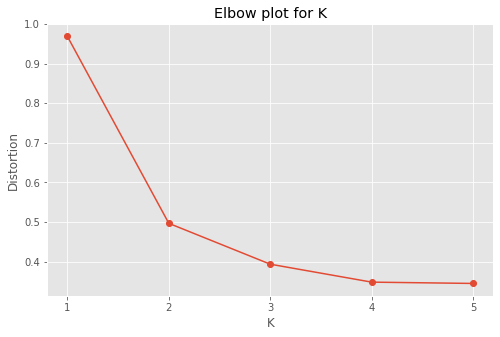

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(list(distortion_measure.keys()), list(distortion_measure.values()), '-o')
plt.xticks(range(1, 6))
plt.title("Elbow plot for K")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()

Based on the elbow plot, we can identify *K* = 3 as the optimal value. Of course we already know it should be 3, as the Iris dataset has 3 types of flowers. Anyway the SSE / distortion measure confirms this class separation of clusters. Now we can use this optimal value ok *K*, to predict class labels and get the final centroids and cluster arrangement.

In [8]:
class_labels = {1:'Iris-setosa', 2:'Iris-versicolor', 3:'Iris-virginica'}

def predict(X, centroids, clusters, target):
    pred_label = []
    for row in X:
        pred_label.append(clusters[np.argmin([cluster_distance(row,sparse.csr_matrix(center)) for center in centroids])])
    return pred_label

In [9]:
k = 3
start_time = time.time()
centroids, cluster_label, clusters = cluster_kmeans(X, y, k)
print("Final centroids array:\n", centroids.toarray())
                                                                                                  
sse = distortion(X, clusters, centroids, k)
print("\nFinal distortion:", np.round(sse, 4))

predicted_class  = predict(X, centroids, cluster_label, class_labels)
accuracy = accuracy_score(y, predicted_class)
print("\nAccuracy of predicted class labels:",np.round(accuracy, 2)*100,'%')

print("\nProgram execution time: %s seconds" % (np.round(time.time() - start_time, 5)))

Final centroids array:
 [[-0.17592596 -0.44618056  0.11793781  0.04166668]
 [ 0.33546999 -0.11378209  0.5143415   0.56410263]
 [-0.60777778  0.18166667 -0.84271174 -0.88000014]]

Final distortion: 0.3932

Accuracy of predicted class labels: 88.0 %

Program execution time: 1.73132 seconds


We achieved an accuracy of 89% using the custom K-Means implementation, which is quite good considering the nature of the dataset, as K-means works best for spherical datasets. We can plot the clusters from the sparse matrix, and recreate the orignal dataset using the discovered cluster arrangements.

In [10]:
dataset = X.toarray()
iris_df = pd.DataFrame({'sepal_length': dataset[:, 0], 'sepal_width': dataset[:, 1], 
                        'petal_length': dataset[:, 2], 'petal_width': dataset[:, 3],})
df2 = pd.DataFrame(predicted_class)
iris_df['class']= df2[0]
iris_df = iris_df.replace({'class': {1.0: 'Iris-setosa', 2.0: 'Iris-versicolor', 3.0: 'Iris-virginica'}})
iris_df.head()

,sepal_length,sepal_width,petal_length,petal_width,class
0,-0.555556,0.250000,-0.864407,-0.916667,Iris-setosa
1,-0.666667,-0.166667,-0.864407,-0.916667,Iris-setosa
2,-0.777778,0.000000,-0.898305,-0.916667,Iris-setosa
3,-0.833333,-0.083333,-0.830508,-0.916667,Iris-setosa
4,-0.611111,0.333333,-0.864407,-0.916667,Iris-setosa


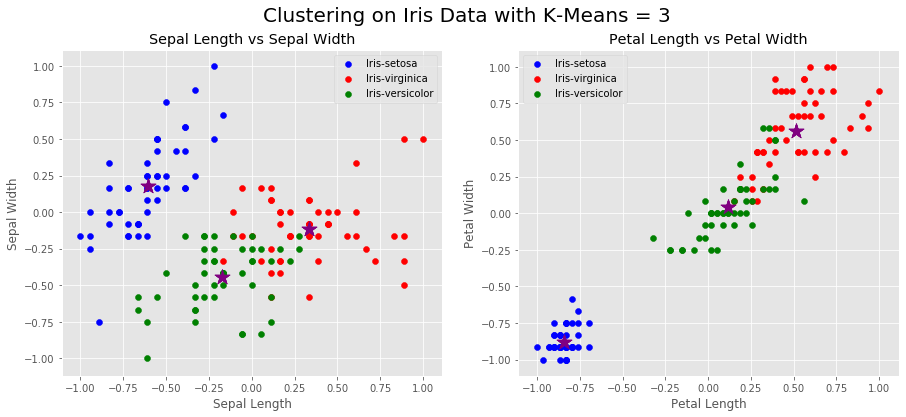

In [11]:
# This is copied directly from my Lab 7 submission, fitted to this sparse dataset.

iris_class = ['1','2','3']
colors = ['blue','red','green']
labels = iris_df['class'].unique()

centers = centroids.toarray()  # Getting cluster centers from the centroids scipy matrix

for k in range(len(labels)):
    iris_class[k] = iris_df[iris_df['class'] == labels[k]]

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Clustering on Iris Data with K-Means = 3', fontsize=20)
for i in range(len(iris_class)):
    ax[0].scatter(iris_class[i].sepal_length, iris_class[i].sepal_width, c=colors[i], label = labels[i])
    ax[0].scatter(centers[:,0], centers[:,1], marker='*', c='purple', s=250)
    ax[0].set_title("Sepal Length vs Sepal Width")
    ax[0].set_xlabel('Sepal Length')
    ax[0].set_ylabel('Sepal Width')
    ax[0].legend()
    
    ax[1].scatter(iris_class[i].petal_length, iris_class[i].petal_width, c=colors[i], label = labels[i])
    ax[1].scatter(centers[:,2], centers[:,3], marker='*', c='purple', s=250)
    ax[1].set_title("Petal Length vs Petal Width")
    ax[1].set_xlabel('Petal Length')
    ax[1].set_ylabel('Petal Width')
    ax[1].legend()
plt.show()

Based on the clusters plot (purple star are the final centroids), we are able to closely recreate and correctly cluster the datapoints as per the original data set.

**What is the fundamental difference between K-means and K-NN?**

K-Means Clustering is an *unsupervised* learning algorithm that is used for clustering whereas K-NN is a *supervised* learning algorithm used for classification (or regression)[5]. The ‘K’ in K-Means Clustering has nothing to do with the ‘K’ in K-NN algorithm. K-means takes a set of unlabeled datapoints and tries to group them into “k” number of clusters.
It is unsupervised because the points have no external classification.

# Part 2: Cluster News Articles

### A. Manual K-means on text dataset

This is a text-based clustering task. We download the dataset from [7]. It consists of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. Each corresponds to a topic. Since they are text documents, we need to do some NLP text processing on it. The main references are from [9,10,11,12] Similar to Lab 9, we can use dump_svmlight_file to make it into Libsvm format, after encoding the target classes to the dataset. Then we can reload the file using load_svmlight_file. We have several helper functions to do the data preprocessing as follows.

In [12]:
import tarfile
try:
    flag = os.path.isdir('./20news-bydate-train')
    if flag == False:
        tar = tarfile.open("20news-bydate.tar.gz")
        tar.extractall()
        tar.close()
    else:
        print('Already unzipped')
except:
    print('Already unzipped')

In [20]:
def fetch20newsgroups(dataset):
    X = []
    y = []
    for category in os.listdir(dataset):
        for fileName in os.listdir(dataset+"/"+str(category)):
            with open(dataset+"/"+str(category)+"/"+str(fileName), 'r') as file:
                X.append(file.read())
                y.append(category)
    return X, y


def nlp_vectorize(train_data, test_data):
    vectorizer = TfidfVectorizer(stop_words = 'english',
                                 min_df=10, 
                                 lowercase = True, 
                                 ngram_range=(1, 3))
    data_train = vectorizer.fit_transform(train_data)
    data_test = vectorizer.transform(test_data)
    return data_train, data_test


def get_target_dict(target):
    target_dict = {}
    index = 1
    for i in set(target):
        target_dict[i] = index
        index += 1
    return target_dict

In [14]:
X_train_data, y_train_data = fetch20newsgroups("20news-bydate-train")
X_test_data, y_test_data = fetch20newsgroups("20news-bydate-test")

In [15]:
type(X_train_data), type(y_train_data)

(list, list)

In [16]:
X_train, X_test = nlp_vectorize(X_train_data, X_test_data)

target_dict = get_target_dict(y_train_data)
y_train = [target_dict[i] for i in y_train_data]
y_test = [target_dict[i] for i in y_test_data]

dump_svmlight_file(X_train, y_train, "train.data", zero_based=False, multilabel=False)
dump_svmlight_file(X_test, y_test, "test.data", zero_based=False, multilabel=False)

In [17]:
X_train, y_train = load_svmlight_file("train.data")
X_train, y_train 

(<11314x32659 sparse matrix of type '<class 'numpy.float64'>'
 	with 1495055 stored elements in Compressed Sparse Row format>,
 array([19., 19., 19., ..., 14., 14., 14.]))

Now that the data is ready, we can train the model on it using the same sparse K-means clustering in Exercise 1.

In [ ]:
distortion_measure = {}
for k in range(18,23):
    centroids,cluster_label,clusters = cluster_kmeans(X_train, y_train, k)
    distortion_measure[k] = distortion(X_train, clusters, centroids, k)

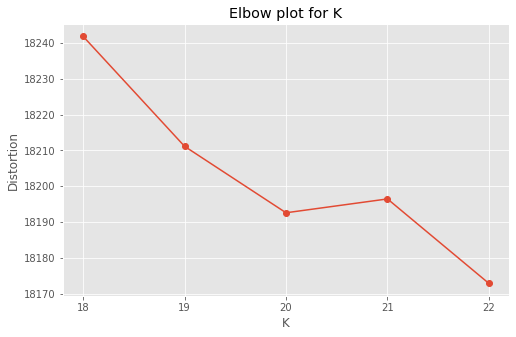

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(list(distortion_measure.keys()), list(distortion_measure.values()), '-o')
plt.xticks(range(18, 23))
plt.title("Elbow plot for K")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()

We already know that *K* = 20, so we can run it on the model using the this value and make prediction on test set and accuracy.

In [10]:
k = 20
start_time = time.time()
centroids, cluster_label, clusters = cluster_kmeans(X_train, y_train, k)                                                                                                  
sse = distortion(X, clusters, centroids, k)
print("\nFinal distortion:", np.round(sse, 4))

predicted_class  = predict(X_test, centroids, cluster_label, class_labels)
accuracy = accuracy_score(y_test, predicted_class)
print("\nAccuracy of predicted class labels:",np.round(accuracy, 2)*100,'%')

print("\nProgram execution time: %s seconds" % (np.round(time.time() - start_time, 5)))


Final distortion: 18218.8816

Accuracy of predicted class labels: 42.0 %

Program execution time: 145.56596 seconds


### B. Sklearn K-means on Text dataset

We can implement this part using sklearns in-built K-means classifier. As we know the news groups, the optimal value of k would be 20. Running for a range of K also takes too long so we only use a small range of values for the elbow plot. The main references are from [9,10].

Using sklearn.Kmeans, we set:
* init=k-means++ default
* max_iter=100
* n_init=1 so it will only run once with one centroid seed. 
All these parameters are to ensure the execution time is lower for this huge dataset. 

The inertia contains the SSE / distortion values, so we store that information for each iteration in a dict.

In [3]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans

news_data = fetch_20newsgroups(subset='all',shuffle=True, random_state=42)

X = news_data.data 
labels = news_data.target 

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

In [19]:
inertia = {}
for k in range(18, 23):
    model = KMeans(n_clusters = k, init='k-means++', max_iter=100, n_init=1)
    model.fit(X)
    inertia[k] = model.inertia_

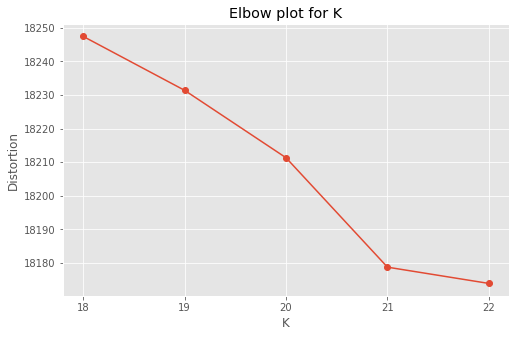

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(list(inertia.keys()), list(inertia.values()), '-o')
plt.xticks(range(18, 23))
plt.title("Elbow plot for K")
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()

From the elbow plot we get the optimal value of *K* as 20, which we know already.

In [25]:
k = 20
start_time = time.time()
model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)
print("\nProgram execution time: %s seconds" % (np.round(time.time() - start_time, 5)))


Program execution time: 143.20954 seconds


We can print the terms to see the centroid arrangement for the 20 clusters.

In [26]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("cluster %d:" % i)
    for ind in order_centroids[i,:20]:
        print('%s' % terms[ind])
    print()

cluster 0:
bike
com
sun
dod
edu
writes
article
ca
msg
ride
east
bmw
behanna
dog
like
riding
rider
bnr
motorcycle
subject

cluster 1:
car
uiuc
edu
cso
cars
com
engine
illinois
writes
urbana
article
uxa
university
just
subject
organization
lines
ford
dealer
don

cluster 2:
gun
stratus
fbi
com
batf
people
edu
koresh
guns
government
sw
waco
atf
cdt
compound
writes
don
article
children
right

cluster 3:
cramer
optilink
clayton
gay
men
homosexual
com
homosexuals
sexual
study
people
sex
consent
partners
pyramid
percentage
promiscuous
mutual
male
relations

cluster 4:
edu
ohio
monitor
state
card
magnus
apple
acs
video
mac
sale
00
university
simms
ram
dartmouth
lines
price
subject
organization

cluster 5:
key
clipper
encryption
chip
keys
escrow
com
government
algorithm
nsa
netcom
crypto
des
sternlight
security
david
secure
wiretap
secret
phone

cluster 6:
windows
dos
file
edu
window
files
ms
program
mouse
os
com
use
drivers
run
using
card
microsoft
version
problem
pc

cluster 7:
nasa
space
gov


In [27]:
from sklearn import metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, model.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, model.labels_))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, model.labels_, sample_size=1000))

Homogeneity: 0.360
Completeness: 0.431
V-measure: 0.392
Silhouette Coefficient: 0.006


### Summary

We can see that the accuracy from the manual implementation of K-Means is really low, compared to sklearn. And the implementation times are longer as well. But this is to be expected, as the sklearn libraries are already optimized. Also the data preprocessing is not clearly stated, so it depends on the various sources I found, as compared to using the built-in dataset from sklearn. Anyway for both cases we managed to get the optimal value of *K*=20.

## References

[1] https://archive.ics.uci.edu/ml/datasets/Iris <br>
[2] https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass/iris.scale <br>
[3] https://stanford.edu/~cpiech/cs221/handouts/kmeans.html <br>
[4] https://mmuratarat.github.io/2019-07-23/kmeans_from_scratch <br>
[5] https://becominghuman.ai/comprehending-k-means-and-knn-algorithms-c791be90883d <br>
[6] https://pythonprogramming.net/k-means-from-scratch-2-machine-learning-tutorial/?completed=/k-means-from-scratch-machine-learning-tutorial/ <br>
[7] http://qwone.com/~jason/20Newsgroups/ <br>
[8] https://stackoverflow.com/questions/42537943/scipy-sparse-matrix-multiplication <br>
[9] https://blog.glugmvit.com/clustering/ <br>
[10] https://www.kaggle.com/carlosaguayo/text-clustering-with-unsupervised-learning <br>
[11] https://pythonprogramminglanguage.com/kmeans-text-clustering/ <br>
[12] https://github.com/khyatith/Clustering-newsgroup-dataset <br>
